# **Baseline U-Net model with batch-normalisation**



## Importing libraries and define paths


In [ ]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
join = os.path.join
from fastai import *
from fastai.vision import *
import tensorflow as tf

import pandas as pd
import math
import random

# Constants
SLICE_Z = True
SLICE_DECIMATE_IDENTIFIER = 3
ED_c = 4    # Correspond to rows in pandas
ES_c = 5
Vendor_c = 2  

In [ ]:
# Pandas read csv file containing ED and ES values
df = pd.read_csv('/content/drive/MyDrive/FYP/MNMS/OpenDataset/201014_M&Ms_Dataset_Information_-_opendataset.csv')

In [ ]:
##### FUNCTIONS #####

# Normalize image function
def normalizeImage(img):
    norm_img = np.zeros((800,800))
    final_img = cv2.normalize(img,  norm_img, 0, 255, cv2.NORM_MINMAX)
    return final_img

# Read image or mask volume
def readImageVolume(imgPath):
    img = nib.load(imgPath).get_fdata()
    return img

# Save volume slice to file
def saveSlice(img, fname, path):
    img = normalizeImage(img)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)

def saveMask(img, fname, path):
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)

def findVendor(vendor, fname, name):
    if vendor=='A':
      name = 'vA_' + fname
    if vendor=='B':
      name = 'vB_' + fname
    if vendor=='C':
      name = 'vC_' + fname
    if vendor=='D':
      name = 'vD_' + fname
    return name
    
# Slice image in all directions and save
def sliceAndSaveVolumeImage(vol, fname, path, mask=False):
    (dimx, dimy, dimz) = vol.shape
    cnt = 0             
    if SLICE_Z:
        if mask:
          cnt += dimz
          for i in range(dimz):
              saveMask(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)           
        else:
            cnt += dimz
            for i in range(dimz):
                saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt

## Loading data and creating train and test arrays

In [ ]:
# Creating the image slices and saving them
train_path = "path to the training images/labelled"
imagePathOutput = "path to output training images"
maskPathOutput = "path to output training masks"

image_idx = os.listdir(train_path)
for i in range(0, len(image_idx)):
    # load each file and save ED, ES volumes from df values
    img = readImageVolume(train_path + image_idx[i] + '/' + image_idx[i] + '_sa.nii.gz')
    ED_volume = img[:,:,:,df.iat[int(df[df['External code']==image_idx[i]].index.values),ED_c]]
    ES_volume = img[:,:,:,df.iat[int(df[df['External code']==image_idx[i]].index.values),ES_c]]
    numOfSlices = sliceAndSaveVolumeImage(ED_volume, image_idx[i] + '-ED', imagePathOutput)
    numOfSlices = sliceAndSaveVolumeImage(ES_volume, image_idx[i] + '-ES', imagePathOutput)

    img = readImageVolume(train_path + image_idx[i] + '/' + image_idx[i] + '_sa_gt.nii.gz')
    ED_volume = img[:,:,:,df.iat[int(df[df['External code']==image_idx[i]].index.values),ED_c]]
    ES_volume = img[:,:,:,df.iat[int(df[df['External code']==image_idx[i]].index.values),ES_c]]
    numOfSlices = sliceAndSaveVolumeImage(ED_volume, image_idx[i] + '-ED', maskPathOutput, mask=True)
    numOfSlices = sliceAndSaveVolumeImage(ES_volume, image_idx[i] + '-ES', maskPathOutput, mask=True)
    print(f'\n{image_idx[i]}, {numOfSlices * 4} slices created \n')

In [ ]:
# Resizing images, if needed
SIZE_X = 128
SIZE_Y = 128
n_classes= 4

In [ ]:
# Capture training image info as a list
train_images = []
for directory_path in glob.glob(imagePathOutput): 
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

# Convert list to array for processing and expand dimensions to (n, 128, 128, 1)       
train_images = np.array(train_images)
train_images = np.expand_dims(train_images, axis = 3)

In [ ]:
# Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob(maskPathOutput):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  # Otherwise ground truth changes due to interpolation
        train_masks.append(mask)

# Convert list to array and expand dimensions to (n, 128, 128, 1) 
train_masks = np.array(train_masks)
train_masks = np.expand_dims(train_masks, axis = 3)

In [ ]:
# Normalize images (not masks)
train_images = train_images /255.

In [ ]:
print("Image data shape is: ", train_images.shape)
print("Mask data shape is: ", train_masks.shape)
print("Max pixel value in image is: ", train_images.max())
print("Labels in the mask are : ", np.unique(train_masks))

In [ ]:
# Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks, test_size = 0.2, random_state = 21)

In [ ]:
# One-hot to_categorical encoding for train_masks -> instead of (n, 128, 128, 1) -> (n, 128, 128, 4)
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
print(y_train_cat.shape)
print(y_test_cat.shape)

(2627, 128, 128, 4)
(657, 128, 128, 4)


## Build U-Net with encoder and decoder blocks

In [ ]:
# Building Unet by dividing encoder and decoder into blocks
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   # Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  # Not in the original network
    x = Activation("relu")(x)

    return x

# Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

# Decoder block
# Skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  # Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  # Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model = build_unet(input_shape, n_classes=4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________

## Training and predictions


In [ ]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Epoch 1/50
165/165 [==============================] - 121s 493ms/step - loss: 0.2122 - accuracy: 0.9546 - val_loss: 0.1834 - val_accuracy: 0.9679
Epoch 2/50
165/165 [==============================] - 77s 466ms/step - loss: 0.0691 - accuracy: 0.9777 - val_loss: 0.1559 - val_accuracy: 0.9580
Epoch 3/50
165/165 [==============================] - 77s 467ms/step - loss: 0.0426 - accuracy: 0.9857 - val_loss: 0.1314 - val_accuracy: 0.9469
Epoch 4/50
165/165 [==============================] - 77s 467ms/step - loss: 0.0289 - accuracy: 0.9900 - val_loss: 0.0395 - val_accuracy: 0.9864
Epoch 5/50
165/165 [==============================] - 77s 467ms/step - loss: 0.0230 - accuracy: 0.9918 - val_loss: 0.0307 - val_accuracy: 0.9906
Epoch 6/50
165/165 [==============================] - 77s 467ms/step - loss: 0.0194 - accuracy: 0.9929 - val_loss: 0.0453 - val_accuracy: 0.9869
Epoch 7/50
165/165 [==============================] - 77s 467ms/step - loss: 0.0187 - accuracy: 0.9930 - val_loss: 0.0375 - val_a

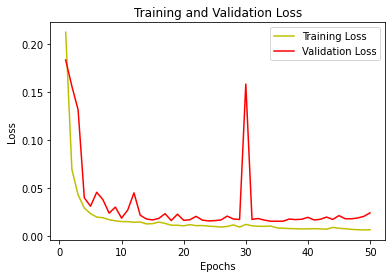

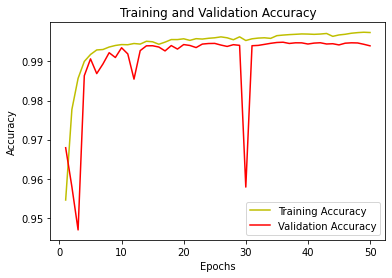

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(657, 128, 128)

In [ ]:
# Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8383869


In [ ]:
# To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[1.041167e+07 1.837000e+03 5.888000e+03 3.801000e+03]
 [2.609000e+03 1.043560e+05 1.045800e+04 4.000000e+00]
 [1.842000e+04 1.937000e+03 9.384900e+04 1.424000e+03]
 [1.741800e+04 1.000000e+00 9.760000e+02 8.964200e+04]]
IoU for class1 is:  0.9952232
IoU for class2 is:  0.8610089
IoU for class3 is:  0.70588636
IoU for class4 is:  0.79142904


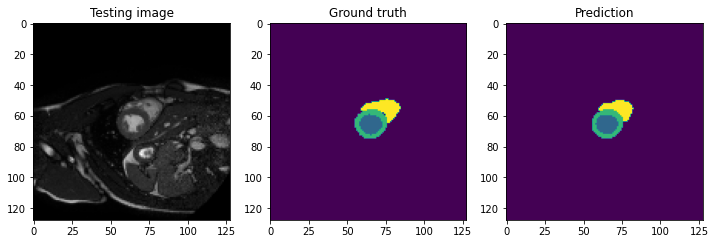

In [ ]:
# Predict on a few images
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Ground truth')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction')
plt.imshow(predicted_img)
plt.show()

# **U-Net model with ImageDataGenerator and dataAugmentation**


## Importing libraries and define paths


In [ ]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
join = os.path.join
from fastai import *
from fastai.vision import *
import tensorflow as tf

import pandas as pd
import math
import random

In [ ]:
train_img_dir = "/content/drive/MyDrive/FYP/MNMS/slices (1)/Out/train_images/train"
train_mask_dir = "/content/drive/MyDrive/FYP/MNMS/slices (1)/Out/train_masks/train"

img_list = os.listdir(train_img_dir)
img_list.sort()  # Very important to sort as we want to match images and masks with same number. 
msk_list = os.listdir(train_mask_dir)
msk_list.sort()
num_images = len(os.listdir(train_img_dir))
print("Total number of training images are: ", num_images)

Total number of training images are:  2627


## Image data generator

In [ ]:
seed=24
batch_size= 16
n_classes=4

from tensorflow.keras.utils import to_categorical
def preprocess_data(img, mask, num_class):
    #Scale images
    img = img / 255. 
    mask = to_categorical(mask, num_class)
      
    return (img, mask)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=False,
                      fill_mode='reflect'
                      )
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        color_mode = 'grayscale',
        target_size=(128,128),
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        target_size=(128,128),
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [ ]:
train_img_path = "/content/drive/MyDrive/FYP/MNMS/slices (1)/Out/train_images"
train_mask_path = "/content/drive/MyDrive/FYP/MNMS/slices (1)/Out/train_masks"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=4)

val_img_path = "/content/drive/MyDrive/FYP/MNMS/slices (1)/Out/val_images"
val_mask_path = "/content/drive/MyDrive/FYP/MNMS/slices (1)/Out/val_masks"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=4)

In [ ]:
x, y = train_img_gen.__next__()

Found 2627 images belonging to 1 classes.
Found 2627 images belonging to 1 classes.


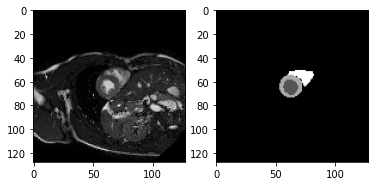

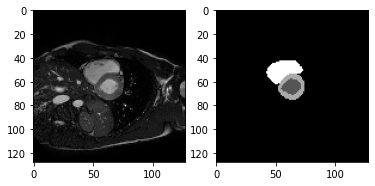

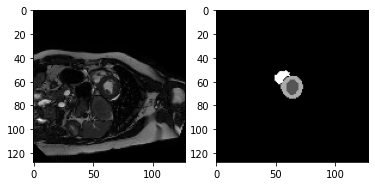

In [ ]:
# Make sure the generator is working and that images and masks are indeed lined up. 
# Verify generator.... In python 3 next() is renamed as __next__()
x, y = train_img_gen.__next__()

for i in range(0,3):
    image = x[i,:,:,0]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

Found 657 images belonging to 1 classes.
Found 657 images belonging to 1 classes.


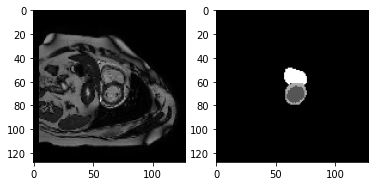

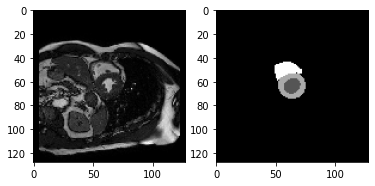

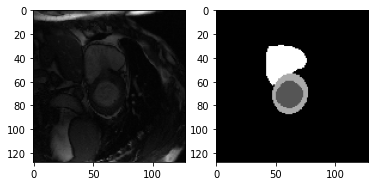

In [ ]:
# Check the val generator as well
x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i,:,:,0]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [ ]:
# Define the model metrics and load model
num_train_imgs = len(os.listdir('/content/drive/MyDrive/FYP/MNMS/slices (1)/Out/train_images/train'))
num_val_images = len(os.listdir('/content/drive/MyDrive/FYP/MNMS/slices (1)/Out/val_images/train'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
n_classes=4

## Build U-Net with encoder and decoder blocks

In [ ]:
# Building Unet by dividing encoder and decoder into blocks
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate

SIZE_Y = 128
SIZE_X = 128
input_shape = (SIZE_Y, SIZE_X, 1)

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   # Batch Normalisation added
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  # Batch Normalisation added
    x = Activation("relu")(x)

    return x

# Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

# Decoder block
# Skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  # Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  # Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
model2 = build_unet(input_shape, n_classes=4)
opt = tf.keras.optimizers.Adam()
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________

## Training and results

In [ ]:
history=model2.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch) 

Epoch 1/50
164/164 [==============================] - 82s 500ms/step - loss: 0.0084 - accuracy: 0.9965 - val_loss: 0.0147 - val_accuracy: 0.9955
Epoch 2/50
164/164 [==============================] - 82s 499ms/step - loss: 0.0081 - accuracy: 0.9966 - val_loss: 0.0149 - val_accuracy: 0.9954
Epoch 3/50
164/164 [==============================] - 82s 499ms/step - loss: 0.0080 - accuracy: 0.9966 - val_loss: 0.0150 - val_accuracy: 0.9954
Epoch 4/50
164/164 [==============================] - 82s 499ms/step - loss: 0.0078 - accuracy: 0.9967 - val_loss: 0.0143 - val_accuracy: 0.9955
Epoch 5/50
164/164 [==============================] - 82s 499ms/step - loss: 0.0078 - accuracy: 0.9967 - val_loss: 0.0141 - val_accuracy: 0.9955
Epoch 6/50
164/164 [==============================] - 82s 499ms/step - loss: 0.0077 - accuracy: 0.9967 - val_loss: 0.0139 - val_accuracy: 0.9956
Epoch 7/50
164/164 [==============================] - 82s 500ms/step - loss: 0.0077 - accuracy: 0.9968 - val_loss: 0.0151 - val_ac

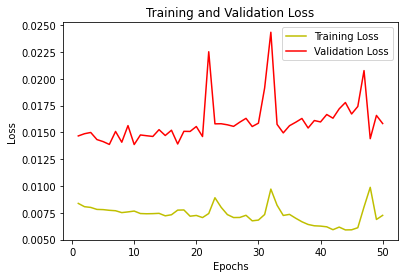

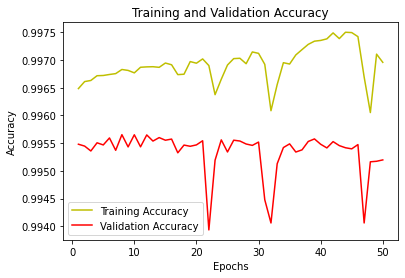

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_image_batch, test_mask_batch = val_img_gen.__next__()
y_pred = model2.predict(test_image_batch)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_argmax = np.argmax(test_mask_batch, axis=3)

In [ ]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.83177894


In [ ]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[2.54287e+05 0.00000e+00 1.70000e+02 9.00000e+01]
 [1.34000e+02 2.96200e+03 1.29000e+02 0.00000e+00]
 [1.86000e+02 1.16000e+02 2.15800e+03 2.00000e+01]
 [4.54000e+02 0.00000e+00 6.50000e+01 1.37300e+03]]
IoU for class1 is:  0.9959502
IoU for class2 is:  0.8865609
IoU for class3 is:  0.75879043
IoU for class4 is:  0.6858142


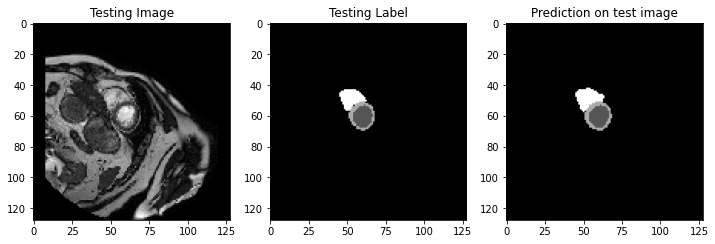

In [ ]:
#Predict on a few images  
import random
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth=test_mask_batch[test_img_number]
ground_truth = np.argmax(ground_truth, axis=2)
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model2.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='gray')
plt.show()

# **Validation testing with new vendors**


## Create the validation data arrays

In [ ]:
val_path = '/content/drive/MyDrive/FYP/MNMS/OpenDataset/Validation/'
val_image_output = '/content/drive/MyDrive/FYP/MNMS/Validation slices/images_vendor/'
val_mask_output = '/content/drive/MyDrive/FYP/MNMS/Validation slices/masks_vendor/'

# Pandas read csv file containing ED and ES values
df = pd.read_csv('/content/drive/MyDrive/FYP/MNMS/OpenDataset/201014_M&Ms_Dataset_Information_-_opendataset.csv')

In [ ]:
# Creating and saving the images 
image_idx = os.listdir(val_path)
for i in range(0, len(image_idx)):
    # find which vendor the image was from and name appropriately
    name = ""
    name = findVendor(df.iat[int(df[df['External code']==image_idx[i]].index.values),Vendor_c], image_idx[i], name)
    # load each file and save ED, ES volumes from df values
    img = readImageVolume(val_path + image_idx[i] + '/' + image_idx[i] + '_sa.nii.gz')
    ED_volume = img[:,:,:,df.iat[int(df[df['External code']==image_idx[i]].index.values),ED_c]]
    ES_volume = img[:,:,:,df.iat[int(df[df['External code']==image_idx[i]].index.values),ES_c]]
    numOfSlices = sliceAndSaveVolumeImage(ED_volume, name + '-ED', val_image_output)
    numOfSlices = sliceAndSaveVolumeImage(ES_volume, name + '-ES', val_image_output)

    img = readImageVolume(val_path + image_idx[i] + '/' + image_idx[i] + '_sa_gt.nii.gz')
    ED_volume = img[:,:,:,df.iat[int(df[df['External code']==image_idx[i]].index.values),ED_c]]
    ES_volume = img[:,:,:,df.iat[int(df[df['External code']==image_idx[i]].index.values),ES_c]]
    numOfSlices = sliceAndSaveVolumeImage(ED_volume, name + '-ED', val_mask_output, mask=True)
    numOfSlices = sliceAndSaveVolumeImage(ES_volume, name + '-ES', val_mask_output, mask=True)
    print(f'\n{image_idx[i]}, {numOfSlices * 4} slices created \n')

In [ ]:
SIZE_Y = 128
SIZE_X = 128

# Capture training image info as a list
val_images = []
for directory_path in glob.glob('/content/drive/MyDrive/FYP/MNMS/Validation slices/images_vendor'): 
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        val_images.append(img)

# Convert list to array for processing and expand dimensions to (n, 128, 128, 1)       
val_images = np.array(val_images)
val_images = np.expand_dims(val_images, axis = 3)

# Capture mask/label info as a list
val_masks = [] 
for directory_path in glob.glob('/content/drive/MyDrive/FYP/MNMS/Validation slices/masks_vendor'):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  # Otherwise ground truth changes due to interpolation
        val_masks.append(mask)

# Convert list to array and expand dimensions to (n, 128, 128, 1) 
val_masks = np.array(val_masks)
val_masks = np.expand_dims(val_masks, axis = 3)

# Normalize images (not masks)
val_images = val_images /255.

In [ ]:
print("Image data shape is: ", val_images.shape)
print("Mask data shape is: ", val_masks.shape)
print("Max pixel value in image is: ", val_images.max())
print("Labels in the mask are : ", np.unique(val_masks))

Image data shape is:  (800, 128, 128, 1)
Mask data shape is:  (800, 128, 128, 1)
Max pixel value in image is:  1.0
Labels in the mask are :  [0 1 2 3]


### Create the validation sets for each vendor


In [ ]:
val_image_output = '/content/drive/MyDrive/FYP/MNMS/Validation slices/images_vendor/'
val_mask_output = '/content/drive/MyDrive/FYP/MNMS/Validation slices/masks_vendor/'

In [ ]:
val_img_A = []
val_img_B = []
val_img_C = []
val_img_D = []

# Create the image vendor lists
for filename in os.listdir('/content/drive/MyDrive/FYP/MNMS/Validation slices/images_vendor'):
    if filename.startswith("vA_"): 
         img = cv2.imread((val_image_output + filename), 0)
         img = cv2.resize(img, (SIZE_Y, SIZE_X))
         val_img_A.append(img)
    if filename.startswith("vB_"):
         img = cv2.imread((val_image_output + filename), 0)
         img = cv2.resize(img, (SIZE_Y, SIZE_X))
         val_img_B.append(img)
    if filename.startswith("vC_"):
         img = cv2.imread((val_image_output + filename), 0)
         img = cv2.resize(img, (SIZE_Y, SIZE_X))
         val_img_C.append(img)
    if filename.startswith("vD_"):
         img = cv2.imread((val_image_output + filename), 0)
         img = cv2.resize(img, (SIZE_Y, SIZE_X))
         val_img_D.append(img)         


val_img_A = np.array(val_img_A)
val_img_A = np.expand_dims(val_img_A, axis = 3)
val_img_B = np.array(val_img_B)
val_img_B = np.expand_dims(val_img_B, axis = 3)
val_img_C = np.array(val_img_C)
val_img_C = np.expand_dims(val_img_C, axis = 3)
val_img_D = np.array(val_img_D)
val_img_D = np.expand_dims(val_img_D, axis = 3)

In [ ]:
# Normalize images (not masks)
val_img_A = val_img_A /255.
val_img_B = val_img_B /255.
val_img_C = val_img_C /255.
val_img_D = val_img_D /255.

In [ ]:
val_mask_A = []
val_mask_B = []
val_mask_C = []
val_mask_D = []

# Create the mask vendor lists
for filename in os.listdir('/content/drive/MyDrive/FYP/MNMS/Validation slices/images_vendor'):
    if filename.startswith("vA_"): 
         mask = cv2.imread((val_mask_output + filename), 0)
         mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
         val_mask_A.append(mask)
    if filename.startswith("vB_"):
         mask = cv2.imread((val_mask_output + filename), 0)
         mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
         val_mask_B.append(mask)
    if filename.startswith("vC_"):
         mask = cv2.imread((val_mask_output + filename), 0)
         mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
         val_mask_C.append(mask)
    if filename.startswith("vD_"):
         mask = cv2.imread((val_mask_output + filename), 0)
         mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
         val_mask_D.append(mask)         


val_mask_A = np.array(val_mask_A)
val_mask_A = np.expand_dims(val_mask_A, axis = 3)
val_mask_B = np.array(val_mask_B)
val_mask_B = np.expand_dims(val_mask_B, axis = 3)
val_mask_C = np.array(val_mask_C)
val_mask_C = np.expand_dims(val_mask_C, axis = 3)
val_mask_D = np.array(val_mask_D)
val_mask_D = np.expand_dims(val_mask_D, axis = 3)

In [ ]:
# Make sure the image and mask lists match up
print(val_img_A.shape + val_img_B.shape + val_img_C.shape + val_img_D.shape)
print(val_mask_A.shape + val_mask_B.shape + val_mask_C.shape + val_mask_D.shape)

(98, 128, 128, 1, 208, 128, 128, 1, 240, 128, 128, 1, 254, 128, 128, 1)
(98, 128, 128, 1, 208, 128, 128, 1, 240, 128, 128, 1, 254, 128, 128, 1)


In [ ]:
val_imgs_all = [val_images, val_img_A, val_img_B, val_img_C, val_img_D]
val_imgs_all = np.array(val_imgs_all, dtype=object)

val_masks_all = [val_masks, val_mask_A, val_mask_B, val_mask_C, val_mask_D]
val_masks_all = np.array(val_masks_all, dtype=object)

names = ["All", "A", "B", "C", "D"]

print(val_imgs_all[0].shape)
print(val_masks_all[0].shape)

(800, 128, 128, 1)
(800, 128, 128, 1)


## Load weights for each method and see results

In [ ]:
#model2.load_weights('/content/drive/MyDrive/FYP/MNMS/19-Sep-DataGen-50epochs.hdf5')  # BL 50 EPOCHS
#model2.load_weights('/content/drive/MyDrive/FYP/MNMS/14-Oct-100epochs.hdf5') # BL 100 EPOCHS

#model2.load_weights('/content/drive/MyDrive/FYP/MNMS/18-Sep-augDataGen-50epochs.hdf5') # AUG (H/V) 50 EPOCHS
#model2.load_weights('/content/drive/MyDrive/FYP/MNMS/19-Sep-augDataGen-100epochs.hdf5')  # AUG (H/V) 100 EPOCHS

#model2.load_weights('/content/drive/MyDrive/FYP/MNMS/10-Oct-augH-50epochs.hdf5')  # H FLIP 50 EPOCHS
#model2.load_weights('/content/drive/MyDrive/FYP/MNMS/augH-100epochs.hdf5')  # H FLIP 100 EPOCHS

#model2.load_weights('/content/drive/MyDrive/FYP/MNMS/simsiam-100epochs-pretrained50epochs.hdf5') # SIMSIAM 50 EPOCHS
#model2.load_weights('/content/drive/MyDrive/FYP/MNMS/simsiam-50epochs-pretrained50epochs.hdf5')  # SIMSIAM 100 EPOCHS

y_pred_argmax_all = []

for i in range(len(val_imgs_all)):
    y_pred=model2.predict(val_imgs_all[i])
    y_pred_argmax=np.argmax(y_pred, axis=3)
    y_pred_argmax_all.append(y_pred_argmax)

#y_pred_argmax_all[0].shape

### Jaccard coefficient (IoU)

In [ ]:
# Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)

for i in range(len(val_imgs_all)):
    IOU_keras.update_state(val_masks_all[i][:,:,:,0], y_pred_argmax_all[i])
    print("Mean IoU " + names[i] +  ":       ", IOU_keras.result().numpy())
    values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
    class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
    class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
    class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
    class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
#   print("IoU for class1 is: ", class1_IoU) # background class not important
    print("IoU for class2 is: ", class2_IoU)
    print("IoU for class3 is: ", class3_IoU)
    print("IoU for class4 is: ", class4_IoU)
    print("\n")

Mean IoU All:        0.8257377
IoU for class2 is:  0.8268869
IoU for class3 is:  0.69365054
IoU for class4 is:  0.78580314


Mean IoU A:        0.82278097
IoU for class2 is:  0.8164001
IoU for class3 is:  0.69556504
IoU for class4 is:  0.7828058


Mean IoU B:        0.82380754
IoU for class2 is:  0.81205666
IoU for class3 is:  0.6935714
IoU for class4 is:  0.7929394


Mean IoU C:        0.8155175
IoU for class2 is:  0.79011136
IoU for class3 is:  0.68803865
IoU for class4 is:  0.78730154


Mean IoU D:        0.8122252
IoU for class2 is:  0.78315103
IoU for class3 is:  0.6818553
IoU for class4 is:  0.78724045




### Dice scores (f1) 

In [ ]:
# Code adapted from https://www.codegrepper.com/code-examples/python/code+to+calculate+dice+score

def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin)
    if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
        return 1
    return (2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin))

def mean_dice_coef(y_true, y_pred_bin):
    # Shape of y_true and y_pred_bin: (n_samples, height, width, n_channels)
    # Includes background
    batch_size = y_true.shape[0]
    channel_num = y_true.shape[-1]
    mean_dice_channel = 0.
    for i in range(batch_size):
        for j in range(channel_num):
            channel_dice = single_dice_coef(y_true[i, :, :, j], y_pred_bin[i, :, :, j])
            mean_dice_channel += channel_dice/(channel_num*batch_size)
    return mean_dice_channel

def channel_dice_coef(y_true, y_pred_bin):
    # Shape of y_true and y_pred_bin: (n_samples, height, width, n_channels)
    batch_size = y_true.shape[0]
    channel_num = y_true.shape[-1]
    channel_dice_coef = 0.
    channel_dsc = []
    for i in range(channel_num):
        for j in range(batch_size):
            channel_dice = single_dice_coef(y_true[j, :, :, i], y_pred_bin[j, :, :, i])
            channel_dice_coef += channel_dice/(batch_size)
        channel_dsc.append(channel_dice_coef)
        channel_dice_coef = 0.
    return channel_dsc

def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

#print(channel_dice_coef(val_masks_cat, y_pred_cat))
#print(mean_dice_coef(val_masks_cat, y_pred_cat))

In [ ]:
from tensorflow.keras.utils import to_categorical
y_pred_cat_all = []
val_masks_cat_all = []

for i in range(len(y_pred_argmax_all)):
    y_pred = np.expand_dims(y_pred_argmax_all[i], axis=3)
    y_pred_cat = to_categorical(y_pred, num_classes=n_classes)
    y_pred_cat = y_pred_cat.reshape((y_pred.shape[0], y_pred.shape[1], y_pred.shape[2], n_classes))
    y_pred_cat_all.append(y_pred_cat)
    val_masks_cat = to_categorical(val_masks_all[i], num_classes=n_classes)
    val_masks_cat = val_masks_cat.reshape((val_masks_all[i].shape[0], val_masks_all[i].shape[1], val_masks_all[i].shape[2], n_classes))
    val_masks_cat_all.append(val_masks_cat)

In [ ]:
for i in range(len(y_pred_cat_all)):
    print("Dice scores " + names[i] + ":")
    print(channel_dice_coef(val_masks_cat_all[i], y_pred_cat_all[i])[1:]) # print from class 1 as bg. not important
    print("Mean DS (inc. bg.): ", mean_dice_coef(val_masks_cat_all[i], y_pred_cat_all[i]))
    print("\n")

Dice scores All:
[0.8714267485886251, 0.7995629463841781, 0.8694481028761877]
Mean DS (inc. bg.):  0.8846807023099807


Dice scores A:
[0.8346315553308429, 0.8324807692471358, 0.868800466170177]
Mean DS (inc. bg.):  0.8832421363956395


Dice scores B:
[0.8165368754319051, 0.8012053076504452, 0.9078389259133115]
Mean DS (inc. bg.):  0.8811427569921464


Dice scores C:
[0.7593964400721662, 0.780691827610266, 0.8408081330142628]
Mean DS (inc. bg.):  0.8447732538679524


Dice scores D:
[0.812381226802329, 0.7686552321994689, 0.8665433038875354]
Mean DS (inc. bg.):  0.8614969566762505




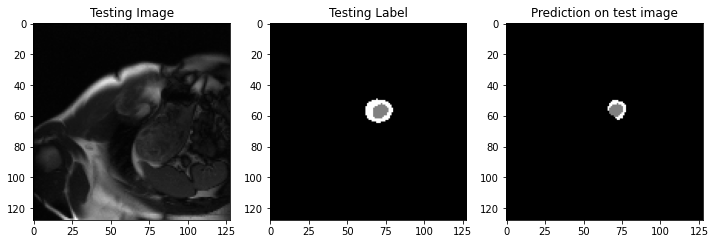

In [ ]:
#Predict on a few images  
import random
test_img_number = random.randint(0, len(val_images)-1)
test_img = val_images[test_img_number]
ground_truth=val_masks[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model2.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0],cmap="gray")
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0],cmap="gray")
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img,cmap="gray")
plt.show()